Overall the temporal model does not explain any of the temporal variance in the data. There are two potential explanations for this failure. First, the observed temporal variation in the labels originates from misreporting in the surveys and not from actual variation in the wealth indicators. In general survey data on consumption expenditure is quite noisy as it involves recalling what a housheold consumed in a given time period prior to the survey date. Thus, parts of the temporal variation in the data might actually originate from misreporting rather than from actual variation in the wealth indicator. If the ratio of variation due to noise in survey answers to actual variation in the wealth indicator is too large, any model will have a hard time learning meaningful mappings between the features and the target variables. Unfortunately, there is no direct way to estimate this ratio. However, I study different channels that affect noise in the training data. 

First: the level of analysis is the cluster level and the target variables are the average response of all households within a cluster. In general, a cluster level average will be more noisy, if it relies on fewer households. Thus, I reduce noise in the target variables by iteratively excluding clusters with fewer than $H_c \in {1,...,15}$ households. I train a model for each value of $H_c$. 

Second: time of survey as quality indicator.

Another source of noise that might affect the performance of models is introduced by jittered geoloactions. I recenter geolocations using the four-step procedure described in section .... Arguably, clusters that are recentered in the first round of the procedure are geographically closer to their true location. Thus, I study whether it makes a difference if clusters are recentered in either of the four steps, by excluding clusters that are recentered in any of the subsequent iterations. 



However, here I empirically assess 



a statistical argument can be made to study this: the level of analysis is the cluster level and the more households to 

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [26]:
# set the font size for matplotlib and the font family.
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

In [3]:
# load the necessary functions from the analysis package

# load the variable names, this allows to access the variables in the feature data in a compact way
from analysis_utils.variable_names import *

# load flagged ids 
from analysis_utils.flagged_uids import *

# load the functions to do spatial k-fold CV
from analysis_utils.spatial_CV import *

# load the helper functions
from analysis_utils.analysis_helpers import *

# load the random forest trainer and cross_validator
import analysis_utils.RandomForest as rf

# load the combien model
from analysis_utils.CombinedModel import CombinedModel

In [4]:
# set the global file paths
root_data_dir = "../../Data"

# the lsms data
lsms_pth = f"{root_data_dir}/lsms/processed/labels_cluster_v1.csv"

# the feature data
feat_data_pth = f"{root_data_dir}/feature_data/tabular_data.csv"

# set the random seed
random_seed = 423
spatial_cv_random_seed = 348

# set the number of folds for k-fold CV
n_folds = 5

In [5]:
# load the feature and the label data
lsms_df = pd.read_csv(lsms_pth)

# remove flagged ids form dataset
lsms_df = lsms_df[~lsms_df.unique_id.isin(flagged_uids)].reset_index(drop = True)

# create average varaibles for the between model
lsms_df['avg_log_mean_pc_cons_usd_2017'] = lsms_df.groupby('cluster_id')['log_mean_pc_cons_usd_2017'].transform('mean')
lsms_df['avg_mean_asset_index_yeh'] = lsms_df.groupby('cluster_id')['mean_asset_index_yeh'].transform('mean')

# load the feature data
feat_df = pd.read_csv(feat_data_pth)

# describe the training data broadly
print(f"Number of observations {len(lsms_df)}")
print(f"Number of clusters {len(np.unique(lsms_df.cluster_id))}")
print(f"Number of x vars {len(feat_df.columns)-2}")

Number of observations 6401
Number of clusters 2128
Number of x vars 113


In [6]:
# merge the label and the feature data to one dataset
lsms_vars = ['unique_id','n_households', 'country', 'lat', 'lon',        
             'log_mean_pc_cons_usd_2017', 'avg_log_mean_pc_cons_usd_2017',
             'mean_asset_index_yeh', 'avg_mean_asset_index_yeh']
df = pd.merge(lsms_df[lsms_vars], feat_df, on = 'unique_id', how = 'left')

In [7]:
df = pd.merge(lsms_df, feat_df, on  = ('cluster_id', 'unique_id'), how = 'left')

In [8]:
# define the x variables and the target variable for the between and within models

# define the between variables
avg_rs_vars = avg_ndvi_vars + avg_ndwi_gao_vars + avg_nl_vars
osm_vars = osm_dist_vars + osm_count_vars + osm_road_vars
between_x_vars = osm_vars + esa_lc_vars + wsf_vars + avg_rs_vars + avg_preciptiation
between_target_var = 'avg_log_mean_pc_cons_usd_2017'

# define the within varaibles
dyn_rs_vars = dyn_ndvi_vars + dyn_ndwi_gao_vars + dyn_nl_vars
within_x_vars = dyn_rs_vars + precipitation 
within_target_var = 'log_mean_pc_cons_usd_2017'

# Different number of households


In [9]:
# define the housheold thresholds
n_households = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
# n_households = [1,2]

# define the between df for this task, inlcuding all necessary variables
between_df = df[['cluster_id', between_target_var, 'n_households'] + between_x_vars].drop_duplicates().reset_index(drop = True)

# define the within df for this task, including all necessary variables
within_df = df[['unique_id', 'cluster_id', within_target_var, 'n_households'] + within_x_vars]

In [10]:
# run the training and valdiation

combined_r2 = []
between_r2 = []
within_r2 = []

for i in n_households:
    print(f"Training on at least {i} Households per cluster")
    
    # subset the datasets to only those observations that meet the condition
    between_df_sub = between_df[between_df['n_households'] >= i].reset_index(drop = True)
    within_df_sub = within_df[within_df['n_households'] >= i].reset_index(drop = True)
    df_sub = df[df['n_households'] >= i].reset_index(drop = True)
    
    # standardise the datasets
    between_df_norm = standardise_df(between_df_sub, exclude_cols = [between_target_var])
    demeaned_df_norm = standardise_df(demean_df(within_df_sub), exclude_cols = [within_target_var])
    
    aux_r2_b = []
    aux_r2_w = []
    aux_r2_c = []
    
    # do 10-times repeated CV: 
    for j in range(10):
        seeed = spatial_cv_random_seed + i + j
        # split the data into training and validation folds
        fold_ids = split_lsms_spatial(df_sub, n_folds = n_folds, random_seed = seeed)

        # run the bewtween training
        print('\n\tBetween model')
        between_cv_trainer = rf.CrossValidator(between_df_norm, 
                                               fold_ids,
                                               between_target_var, 
                                               between_x_vars, 
                                               id_var = 'cluster_id',
                                               random_seed = seeed)
        between_cv_trainer.run_cv_training(min_samples_leaf = 1)
        between_res = between_cv_trainer.compute_overall_performance()

        # run the within training
        print('\n\tWithin Model')
        within_cv_trainer = rf.CrossValidator(demeaned_df_norm, 
                                              fold_ids, 
                                              within_target_var, 
                                              within_x_vars,
                                              id_var = 'unique_id',
                                              random_seed = seeed)
        within_cv_trainer.run_cv_training(min_samples_leaf = 1)
        within_res = within_cv_trainer.compute_overall_performance()

        # run the combined model
        combined_model = CombinedModel(df_sub, between_cv_trainer, within_cv_trainer)
        combined_model.evaluate()
        combined_res = combined_model.compute_overall_performance()
        print(f"\t{combined_res['r2']}")

        # store results
        aux_r2_b.append(combined_res['r2']['between'])
        aux_r2_w.append(combined_res['r2']['within'])
        aux_r2_c.append(combined_res['r2']['combined'])
    
    between_r2.append(aux_r2_b)
    within_r2.append(aux_r2_w)
    combined_r2.append(aux_r2_c)
    
    print('\n\n\n')


Training on at least 1 Households per cluster
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 133 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 289 seconds
	{'combined': 0.37304968490558427, 'between': 0.4500568985559014, 'within': -0.016164244618326752}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 131 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 285 seconds
	{'combined': 0.39583584437693775, 'between': 0.4803684306254626, 'within': -0.024650844747643296}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.17

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 139 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 283 seconds
	{'combined': 0.36949617214173236, 'between': 0.4511383156551728, 'within': -0.01600670772236712}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.23
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.16

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 133 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 287 seconds
	{'combined': 0.37995103178858525, 'between': 0.4578841373568325, 'within': -0.02291855916820775}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.26
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.13

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 147 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 279 seconds
	{'combined': 0.39292398731662315, 'between': 0.47197616845570284, 'within': -0.022456719832581705}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 137 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 284 seconds
	{'combined': 0.39982928095852344, 'between': 0.4800900580200512, 'within': -0.010752590167958199}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.25
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.14

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 137 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 283 seconds
	{'combined': 0.38595181668314715, 'between': 0.4656794952928928, 'within': -0.014798669541319143}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.23
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.16

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 133 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 289 seconds
	{'combined': 0.3810376805303637, 'between': 0.4674557087734256, 'within': -0.018701676952764146}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 145 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 286 seconds
	{'combined': 0.38923296740023716, 'between': 0.47206736032722074, 'within': -0.02460963098772473}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 132 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 285 seconds
	{'combined': 0.3747744864939166, 'between': 0.44826685777981834, 'within': -0.025686376128564503}




Training on at least 2 Households per cluster
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 137 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 277 seconds
	{'combined': 0.4015729288322234, 'between': 0.4820418479116391, 'within': -0.012441180334801304}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.25
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.15

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 130 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 276 seconds
	{'combined': 0.4090109508004495, 'between': 0.480215476596779, 'within': -0.005041498155516644}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.17

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 142 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 273 seconds
	{'combined': 0.4015483866348888, 'between': 0.47480962554139655, 'within': -0.008928444034803085}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.23
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.15

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 133 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 275 seconds
	{'combined': 0.3931694664164373, 'between': 0.47296720941891945, 'within': -0.010497985699760081}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.24
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.15

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 133 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 273 seconds
	{'combined': 0.39767388384734337, 'between': 0.47506104114677805, 'within': -0.021031998266851603}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.26
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.13

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 136 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 273 seconds
	{'combined': 0.39016766887116594, 'between': 0.4675336349305232, 'within': -0.015418015139460128}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 131 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 285 seconds
	{'combined': 0.3783725697344295, 'between': 0.4527088480674082, 'within': -0.011380401988509582}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 131 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 287 seconds
	{'combined': 0.39291006992242083, 'between': 0.46255040279849646, 'within': -0.013019361621420412}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.17

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 137 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 280 seconds
	{'combined': 0.39669974090937, 'between': 0.4693623589802812, 'within': -0.01483927167543051}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 142 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 270 seconds
	{'combined': 0.3991155280854782, 'between': 0.47633481457188803, 'within': -0.01872390755462818}




Training on at least 3 Households per cluster
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 131 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 263 seconds
	{'combined': 0.4038197990192309, 'between': 0.4696729160380202, 'within': -0.011177060336089362}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.23
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.16

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 131 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 264 seconds
	{'combined': 0.43444986711259426, 'between': 0.4978281781203546, 'within': -0.011723323241087246}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.26
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.14

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 130 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 261 seconds
	{'combined': 0.4020562375371734, 'between': 0.4790905721699752, 'within': -0.015785688879906324}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 128 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 267 seconds
	{'combined': 0.43297615276077844, 'between': 0.5031716804261719, 'within': -0.015366383184360921}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 125 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 263 seconds
	{'combined': 0.384133477887641, 'between': 0.4466711511187576, 'within': -0.012832008553677988}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 136 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 270 seconds
	{'combined': 0.40064754618811255, 'between': 0.4814339361264765, 'within': -0.010885223074388061}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.23
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.17

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 127 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 264 seconds
	{'combined': 0.4069140326265833, 'between': 0.4800475565544467, 'within': -0.013741747131286819}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.23
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.16

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 135 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 264 seconds
	{'combined': 0.3772473568814848, 'between': 0.44621609664514494, 'within': -0.023442159270566365}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.23
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.16

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 133 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 260 seconds
	{'combined': 0.42222312270540596, 'between': 0.49709381434752925, 'within': -0.018529319015726232}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 133 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 262 seconds
	{'combined': 0.37361474643371134, 'between': 0.44475770507754614, 'within': -0.0068852738493162535}




Training on at least 4 Households per cluster
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 128 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 249 seconds
	{'combined': 0.3927717931428341, 'between': 0.4640381432746888, 'within': -0.013373214608738282}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.23
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.16

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 127 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 248 seconds
	{'combined': 0.41130051546069035, 'between': 0.48505776714088455, 'within': -0.021717281584239377}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.25
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.14

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 128 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 247 seconds
	{'combined': 0.4152969606597678, 'between': 0.48170904060388764, 'within': -0.01546611770806865}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.26
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.13

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 127 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 251 seconds
	{'combined': 0.39914543434813593, 'between': 0.4717293543535382, 'within': -0.024852610681231367}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 142 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 276 seconds
	{'combined': 0.38563369839234296, 'between': 0.45979584939420737, 'within': -0.018312605058344155}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.26
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.13

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 141 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 274 seconds
	{'combined': 0.3993911282731315, 'between': 0.46556083038004853, 'within': -0.012134119338804395}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 142 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 277 seconds
	{'combined': 0.3979173172490521, 'between': 0.472548932014738, 'within': -0.012573778597832907}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.23
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.17

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 142 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 275 seconds
	{'combined': 0.4083921812253616, 'between': 0.47806956771010983, 'within': -0.0173296965048495}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.25
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.14

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 143 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 275 seconds
	{'combined': 0.3984996078751471, 'between': 0.4759935392065294, 'within': -0.019125357226384733}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 145 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 275 seconds
	{'combined': 0.384360090047505, 'between': 0.4554584431125086, 'within': -0.016300107674143537}




Training on at least 5 Households per cluster
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.23
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.16

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 137 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 258 seconds
	{'combined': 0.40387906622391123, 'between': 0.48085928164079034, 'within': -0.014422503395477505}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.17

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 135 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 258 seconds
	{'combined': 0.40704400093735515, 'between': 0.47561755218212615, 'within': -0.02311010521659367}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.17

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 137 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 240 seconds
	{'combined': 0.40412733960654557, 'between': 0.47654344561444156, 'within': -0.01048226515379531}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.24
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.15

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 126 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 234 seconds
	{'combined': 0.4109849402915917, 'between': 0.4846201168352521, 'within': -0.024562810901136302}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.24
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.15

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 124 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 233 seconds
	{'combined': 0.4164937360767835, 'between': 0.4957138794820995, 'within': -0.023730494975179272}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.16

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 123 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 235 seconds
	{'combined': 0.38857648009822726, 'between': 0.4512811206426201, 'within': -0.024532714509945118}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.24
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.15

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 120 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 235 seconds
	{'combined': 0.40969397921848566, 'between': 0.4779488783835824, 'within': -0.023995433682989176}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 123 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 236 seconds
	{'combined': 0.40822460517456644, 'between': 0.48786411109801214, 'within': -0.021430353562614267}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.16

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 121 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 236 seconds
	{'combined': 0.39421512783434465, 'between': 0.4662060014091279, 'within': -0.01823702465871575}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 123 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 234 seconds
	{'combined': 0.3944509393564149, 'between': 0.4632029267325791, 'within': -0.023306306133480927}




Training on at least 6 Households per cluster
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 114 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 216 seconds
	{'combined': 0.3980063732525417, 'between': 0.47233611526315744, 'within': -0.014050294681499964}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 114 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 214 seconds
	{'combined': 0.38868852190847775, 'between': 0.46722736729660713, 'within': -0.016838341437688965}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 116 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 214 seconds
	{'combined': 0.3818989139276464, 'between': 0.457076591255091, 'within': -0.021840774690428732}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.17

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 120 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 212 seconds
	{'combined': 0.39925065774415497, 'between': 0.4661695343688313, 'within': -0.01689681423948821}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.24
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.15

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 116 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 214 seconds
	{'combined': 0.40312798031550606, 'between': 0.4819940758200846, 'within': -0.017869899760827312}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.17

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 115 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 213 seconds
	{'combined': 0.37710954998467233, 'between': 0.44855844647265986, 'within': -0.020885344362536685}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.17

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 115 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 212 seconds
	{'combined': 0.39184570475325986, 'between': 0.4682353061831583, 'within': -0.0139518765602191}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 115 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 211 seconds
	{'combined': 0.3873511111463544, 'between': 0.46492610968716874, 'within': -0.021793839445805173}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 117 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 212 seconds
	{'combined': 0.389713425771135, 'between': 0.4676122291292445, 'within': -0.01767555093135358}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 114 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 212 seconds
	{'combined': 0.39378833427524956, 'between': 0.476442059862185, 'within': -0.019044763881067926}




Training on at least 7 Households per cluster
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 104 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 183 seconds
	{'combined': 0.4064482613234763, 'between': 0.48066479929891953, 'within': -0.02081998827716376}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.17

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 100 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 185 seconds
	{'combined': 0.38848706026435875, 'between': 0.4622161505547575, 'within': -0.019462874068107004}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 103 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 187 seconds
	{'combined': 0.3826442725284576, 'between': 0.4567444246953719, 'within': -0.026290649127719147}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 102 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 189 seconds
	{'combined': 0.3900307197684929, 'between': 0.4679212588397742, 'within': -0.03485215113516023}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 96 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 186 seconds
	{'combined': 0.3785820071854382, 'between': 0.45677581466425565, 'within': -0.02424277374549457}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 96 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 186 seconds
	{'combined': 0.3729311158705215, 'between': 0.44712315832697885, 'within': -0.020724211499756874}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 97 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 185 seconds
	{'combined': 0.3658611675900574, 'between': 0.43208547745251036, 'within': -0.029154210247227152}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 97 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 186 seconds
	{'combined': 0.3644949190659832, 'between': 0.4332801715735525, 'within': -0.02833531191053331}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 97 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 185 seconds
	{'combined': 0.3933153669293336, 'between': 0.46881932573141044, 'within': -0.024799346971132508}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 97 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 186 seconds
	{'combined': 0.38965121487794097, 'between': 0.4599815926780713, 'within': -0.022148043748618295}




Training on at least 8 Households per cluster
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 79 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 136 seconds
	{'combined': 0.3938594595724918, 'between': 0.46478441218923555, 'within': -0.00925451787619953}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.17

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 76 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 132 seconds
	{'combined': 0.37680192301304805, 'between': 0.4434931385841679, 'within': -0.025115154806272223}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.23
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.16

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 79 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 130 seconds
	{'combined': 0.3925722474884017, 'between': 0.45852903372774295, 'within': -0.021705960602578612}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 76 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 132 seconds
	{'combined': 0.3913910652621469, 'between': 0.46315733225631417, 'within': -0.016235346978229127}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.17

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 78 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 133 seconds
	{'combined': 0.39762835183467093, 'between': 0.47030037650500506, 'within': -0.01391725478329553}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.16

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 77 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 131 seconds
	{'combined': 0.3897654917052118, 'between': 0.4639312168409183, 'within': -0.023860644835378288}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 77 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 133 seconds
	{'combined': 0.3748532092426013, 'between': 0.44740629412532484, 'within': -0.020227658060879783}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 77 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 134 seconds
	{'combined': 0.3717401400900071, 'between': 0.4454341486024459, 'within': -0.014625859697478205}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 77 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 132 seconds
	{'combined': 0.39119335563315766, 'between': 0.46122909995229033, 'within': -0.0166055914099019}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 77 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 131 seconds
	{'combined': 0.3760824836058937, 'between': 0.4430265219104446, 'within': -0.014878395392242427}




Training on at least 9 Households per cluster
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.17

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 61 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 93 seconds
	{'combined': 0.36628746920241373, 'between': 0.4296993484121079, 'within': -0.023601669669008517}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.15

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 58 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 92 seconds
	{'combined': 0.3688602137923231, 'between': 0.43670448845051074, 'within': -0.011656184215954112}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.17

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 58 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 92 seconds
	{'combined': 0.3765197814360403, 'between': 0.44633991488187463, 'within': -0.011067848354811827}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.17

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 58 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 92 seconds
	{'combined': 0.36456965770295746, 'between': 0.4360614808217971, 'within': -0.012799439391675627}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.17

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 57 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 91 seconds
	{'combined': 0.3761097255797798, 'between': 0.4493854644109718, 'within': -0.022453736470958562}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.15

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 58 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 91 seconds
	{'combined': 0.34033187597326686, 'between': 0.3984121427056495, 'within': -0.008228474829072496}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.17

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 57 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 92 seconds
	{'combined': 0.3701026985721565, 'between': 0.43925674173572377, 'within': -0.012187381914412843}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 57 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 92 seconds
	{'combined': 0.37766546563636727, 'between': 0.4479992605853601, 'within': -0.027605560326654156}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 58 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 92 seconds
	{'combined': 0.39045604611037266, 'between': 0.4691595332638884, 'within': -0.014987060396362505}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.15

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 58 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 92 seconds
	{'combined': 0.3854038494894894, 'between': 0.4586617242478117, 'within': -0.02334027430793457}




Training on at least 10 Households per cluster
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.17

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 50 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 74 seconds
	{'combined': 0.3175629696371384, 'between': 0.38439854400449835, 'within': -0.026992211177390146}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.23
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.16

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 50 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 73 seconds
	{'combined': 0.31934918085187475, 'between': 0.38305974542895316, 'within': -0.02557712371677412}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.23
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.16

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 50 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 73 seconds
	{'combined': 0.27968047082256997, 'between': 0.3463541184332253, 'within': -0.0411900166857138}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.17

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 50 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 74 seconds
	{'combined': 0.3011258691016717, 'between': 0.36880372253006033, 'within': -0.036504910764082354}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.23
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.16

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 50 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 73 seconds
	{'combined': 0.2538055677130938, 'between': 0.30473739770013875, 'within': -0.03613596129100842}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.15

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 51 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 74 seconds
	{'combined': 0.3345680643646717, 'between': 0.40391636417659427, 'within': -0.030291102071954158}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.17

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 50 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 74 seconds
	{'combined': 0.31699180361693413, 'between': 0.3796676225873537, 'within': -0.029669357139398046}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.23
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.16

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 51 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 73 seconds
	{'combined': 0.34463140958564725, 'between': 0.4221200204362953, 'within': -0.027224914424199942}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.23
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.16

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 50 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 73 seconds
	{'combined': 0.32857002162124144, 'between': 0.3912370714479897, 'within': -0.02407310407281693}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.17

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 50 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 73 seconds
	{'combined': 0.30614144234381535, 'between': 0.36635094909641036, 'within': -0.027169056996463416}




Training on at least 11 Households per cluster
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.16

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 39 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 49 seconds
	{'combined': 0.32082713624409315, 'between': 0.3739412403378391, 'within': -0.046897804896653336}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.23
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.14

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 38 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 48 seconds
	{'combined': 0.36252488892862966, 'between': 0.420381670442532, 'within': -0.016046452698924907}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.17

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 38 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 48 seconds
	{'combined': 0.24212030731143624, 'between': 0.2849559831827238, 'within': -0.021376030719712856}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.23
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.16

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 39 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 48 seconds
	{'combined': 0.34891195766662675, 'between': 0.4080739344406865, 'within': -0.05206807574207486}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.15

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 38 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 48 seconds
	{'combined': 0.2820204221033237, 'between': 0.3522365691165216, 'within': -0.05780451743182602}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.23
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.16

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 38 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 48 seconds
	{'combined': 0.3355402856199696, 'between': 0.3912266326978301, 'within': -0.014312247937368561}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.17

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 38 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 48 seconds
	{'combined': 0.29359980053977525, 'between': 0.34054963713551417, 'within': -0.0365520083135803}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 39 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 48 seconds
	{'combined': 0.34609153595880005, 'between': 0.4089867575012183, 'within': -0.05608865828234666}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.24
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.12

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 38 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 48 seconds
	{'combined': 0.30984686057866684, 'between': 0.3709302697297481, 'within': -0.04191533589054062}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 38 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 48 seconds
	{'combined': 0.2874465262701196, 'between': 0.317742995369327, 'within': -0.041122168090303425}




Training on at least 12 Households per cluster
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.23
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.24
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.13

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 39 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 41 seconds
	{'combined': 0.20232450909047617, 'between': 0.2285480389313624, 'within': -0.0362859363817362}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.17

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 35 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 41 seconds
	{'combined': 0.24011651684207205, 'between': 0.2904479413746178, 'within': -0.05297083999042664}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.23
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.15

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 35 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 41 seconds
	{'combined': 0.23015286907285148, 'between': 0.27556752063713297, 'within': -0.057925027098551074}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.23
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.24
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.11

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 36 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 41 seconds
	{'combined': 0.28172418556739837, 'between': 0.3260270579949187, 'within': -0.07270291682275223}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.15

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 36 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 41 seconds
	{'combined': 0.241418746344297, 'between': 0.2814065326258057, 'within': -0.048397201776502995}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.23
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.15

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 36 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 41 seconds
	{'combined': 0.1801718209168665, 'between': 0.19596801636796699, 'within': -0.08188224553522391}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.15

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 35 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 41 seconds
	{'combined': 0.29683787568619546, 'between': 0.33354464489469104, 'within': -0.023456219186364403}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.26
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.13

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 35 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 41 seconds
	{'combined': 0.1720426436197989, 'between': 0.2239115931631681, 'within': -0.09181828326047628}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.17

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 35 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 40 seconds
	{'combined': 0.2764103841904027, 'between': 0.3285618695311437, 'within': -0.042846410619498274}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.15

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 36 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 41 seconds
	{'combined': 0.2420081435045705, 'between': 0.27724006122219097, 'within': -0.017685143741102128}




Training on at least 13 Households per cluster
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.25
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.10

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 32 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 33 seconds
	{'combined': 0.20467894694523137, 'between': 0.22671670567365504, 'within': -0.007401366496020701}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.23
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.16

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 32 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 33 seconds
	{'combined': 0.016742700071247233, 'between': 0.02583637212963905, 'within': -0.1525952445732231}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.15

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 32 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 34 seconds
	{'combined': 0.1378867873089568, 'between': 0.12647536832074668, 'within': 0.005007733423826677}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.23
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.23
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.12

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 32 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 33 seconds
	{'combined': 0.2681922216867093, 'between': 0.30927956288041736, 'within': -0.04089613088944688}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 31 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 33 seconds
	{'combined': 0.06719493316893338, 'between': 0.03808190172517803, 'within': -0.01208822137108052}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.15

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 32 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 33 seconds
	{'combined': 0.22215177276484782, 'between': 0.24145393253757758, 'within': -0.03749807623829571}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.16

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 32 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 34 seconds
	{'combined': 0.10812148641648364, 'between': 0.11585011967293844, 'within': -0.03639117496135844}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.25
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.11

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 32 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 33 seconds
	{'combined': 0.2351241010579026, 'between': 0.2645642206573386, 'within': -0.017420180520188122}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.23
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.14

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 32 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 33 seconds
	{'combined': 0.11938607727918803, 'between': 0.13016309003588872, 'within': 0.011243238610720473}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.26
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.12

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 32 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 33 seconds
	{'combined': 0.13579560395768134, 'between': 0.177496160721269, 'within': -0.1521184281982622}




Training on at least 14 Households per cluster
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.16

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 30 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 31 seconds
	{'combined': 0.19786542967076648, 'between': 0.1981960492841006, 'within': 0.12357330096395758}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.14

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 30 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 31 seconds
	{'combined': 0.16342032101781845, 'between': 0.15291275339370206, 'within': 0.10442820116308198}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.25
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.11

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 30 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 31 seconds
	{'combined': 0.00230227500411296, 'between': -0.059237259856618214, 'within': 0.1580495957067719}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.17

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 30 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 31 seconds
	{'combined': 0.016639935010208454, 'between': -0.006982942512204909, 'within': 0.07524912900008104}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.24
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.13

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 30 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 31 seconds
	{'combined': 0.17145565141911515, 'between': 0.1660982236285138, 'within': 0.11610453812402541}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.23
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.14

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 30 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 31 seconds
	{'combined': 0.21389745889416745, 'between': 0.2266942653488232, 'within': 0.04256771220531323}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.24
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.14

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 30 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 31 seconds
	{'combined': 0.16990406367844932, 'between': 0.1591998300647013, 'within': 0.10168301457841411}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.26
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.13

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 30 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 31 seconds
	{'combined': 0.18148942626443007, 'between': 0.18855615070010284, 'within': 0.06884295977745106}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.14

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 30 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 31 seconds
	{'combined': 0.005177087187613026, 'between': -0.03703105757028284, 'within': 0.10883594097754386}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.28
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.09

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 30 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 31 seconds
	{'combined': 0.0935728624615602, 'between': 0.05858927818799159, 'within': 0.1076626671295691}




Training on at least 15 Households per cluster
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.27
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.23
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.09

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 29 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 29 seconds
	{'combined': 0.05059175311498381, 'between': 0.044414008927046715, 'within': -0.11100747690365051}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.24
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.18
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.14

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 28 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 29 seconds
	{'combined': 0.09435954568618911, 'between': 0.08440056884744807, 'within': -0.06056822581496968}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.23
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.19
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.15

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 29 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 29 seconds
	{'combined': 0.02401374225397445, 'between': -0.014842359077408234, 'within': -0.1019741674798639}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.23
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.23
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.18
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.18
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.17

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 29 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 29 seconds
	{'combined': 0.1463815280527959, 'between': 0.17362047829025007, 'within': -0.019744644114241972}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.23
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.11

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 29 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 29 seconds
	{'combined': -0.19280921674426507, 'between': -0.36430330851944176, 'within': -0.04027665991141562}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.27
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.22
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.19
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.19
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.13

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 28 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 29 seconds
	{'combined': -0.005495535623734116, 'between': -0.07067289731005283, 'within': -0.03514678355768526}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.28
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.24
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.19
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.09

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 28 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 29 seconds
	{'combined': 0.24455861279674973, 'between': 0.2794757600379931, 'within': 0.06746796374853432}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.24
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.26
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.23
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.06

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 29 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 29 seconds
	{'combined': 0.1194618544796425, 'between': 0.053702646626706624, 'within': 0.03571966479824899}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.23
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.18
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.17

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 28 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 29 seconds
	{'combined': 0.11305980466384724, 'between': 0.0929624871761528, 'within': 0.03494952421288733}
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.26
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.24
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.18
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.11

	Between model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 28 seconds

	Within Model
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 29 seconds
	{'combined': 0.10843572566752031, 'between': 0.09587713272475552, 'within': -0.04940350786231518}






In [13]:
results = {
    'between_r2': np.array(between_r2),
    'within_r2': np.array(within_r2),
    'combined_r2': np.array(combined_r2)
}

# take the average over the repeated CV results
agg_results = {k: np.mean(v, axis = 1) for k,v in results.items()}

# save the results
pth = "../results/robust_households.pkl"
with open(pth, 'wb') as f:
    pickle.dump(results, f)

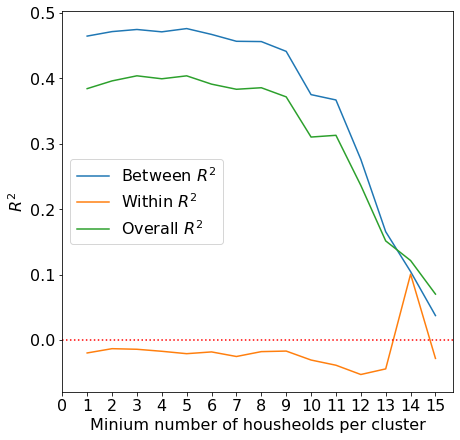

In [32]:
# plot the results
plt.figure(figsize = (7,7))
plt.plot(list(range(1,16)), agg_results['between_r2'], label = 'Between $R^2$')
plt.plot(list(range(1,16)), agg_results['within_r2'], label = 'Within $R^2$')
plt.plot(list(range(1,16)), agg_results['combined_r2'], label = 'Overall $R^2$')
plt.legend()
plt.xlabel("Minium number of housheolds per cluster")
plt.ylabel("$R^2$")
plt.axhline(y=0, color='red', linestyle='dotted', label='y = 0')  # Add red dotted line at y = 0
plt.xticks(range(0, 16))  # Set x-axis ticks from 1 to 10
plt.savefig("../figures/results/R2_vs_households.png", dpi = 600, bbox_inches = 'tight', pad_inches = 0.1)
plt.show() 

# Nightlights are noisy which is why no signal

In [ ]:
early_years 

# Run different models for Urban and Rural

In [ ]:
urban_cids = list(df[df.rural == 0].cluster_id)
rural_cids = list(df[df.rural == 1].cluster_id)

# Ensure T years between cluster-year observations

In [ ]:
# two years (drop uganda I and II 2010, and uganda I 2018)
# three years (drop Ethiopia I 2013 and Ethiopia II, drop Nigeria I II 2012, Tanzania I 2010, 2012, Tanzania III 2010, Uganda I 2011, 2015 Uganda II)
min_year_1_ids = {'uids': list(df.unique_id), 
                   'cids': list(df.cluster_id)}

# create sample with time differences of at least 2 years:
condition_1 = (df.country == 'uga') & (df.start_year == 2010)
condition_2 = (df.country == 'uga') & (df.series == 'long') & (df.start_year == 2018)
condition_2_years = condition_1 | condition_2
min_year_2_ids = {'uids': list(df[~condition_2_years].unique_id),
                   'cids': list(df[~condition_2_years].cluster_id)}


# create sample with time differences of at least 3 years:

# drop Ethiopia I 2013 and Ethiopia II
eth_cond = ((df.country == 'eth') & (df.start_year == 2013)) | ((df.country == 'eth') & (df.series == 'short'))

# drop Nigeria I II 2012
nga_cond = ((df.country == 'nga') & (df.start_year == 2012))

# drop Tanzania I 2010, 2012, Tanzania III 2010
tza_cond_1 = (df.country == 'tza') & (df.start_year == 2010)
tza_cond_2 = (df.country == 'tza') & (df.series == 'long') & (df.start_year == 2012)
tza_cond = tza_cond_1 | tza_cond_2

# drop Uganda I 2011, 2015 Uganda II
uga_cond_1 = (df.country == 'uga') & (df.series == 'short')
uga_cond_2 = (df.country == 'uga') & (df.start_year.isin([2010, 2011, 2015, 2018]))
uga_cond = uga_cond_1 | uga_cond_2

# combine all conditions
condition_3_years = eth_cond | nga_cond | tza_cond | uga_cond

min_year_3_ids = {'uids': list(df[~condition_3_years].unique_id),
                  'cids': list(df[~condition_3_years].cluster_id)}

In [ ]:
# run the training and valdiation
min_year_ids = [min_year_1_ids, min_year_2_ids, min_year_3_ids]

combined_r2 = []
between_r2 = []
within_r2 = []

for idx, ids in enumerate(min_year_ids):
    print(f"Training on at least {idx+1} years of difference between waves")
    
    between_df_sub = between_df[between_df['cluster_id'].isin(ids['cids'])].reset_index(drop = True)
    within_df_sub = within_df[within_df['unique_id'].isin(ids['uids'])].reset_index(drop = True)
    
    df_sub = df[df['unique_id'].isin(ids['uids'])].reset_index(drop = True)
    
    fold_ids = split_lsms_spatial(df_sub, n_folds = n_folds, random_seed = spatial_cv_random_seed)
    
    between_df_norm = standardise_df(between_df_sub, exclude_cols = [between_target_var])
    demeaned_df_norm = standardise_df(demean_df(within_df_sub), exclude_cols = [within_target_var])
    
    # run the bewtween training
    print('\n\tBetween model')
    between_cv_trainer = rf.CrossValidator(between_df_norm, 
                                           fold_ids,
                                           between_target_var, 
                                           between_x_vars, 
                                           id_var = 'cluster_id',
                                           random_seed = random_seed)
    between_cv_trainer.run_cv_training(min_samples_leaf = 1)
    between_res = between_cv_trainer.compute_overall_performance()
    
    # run the within training
    print('\n\tWithin Model')
    within_cv_trainer = rf.CrossValidator(demeaned_df_norm, 
                                          fold_ids, 
                                          within_target_var, 
                                          within_x_vars,
                                          id_var = 'unique_id',
                                          random_seed = random_seed)
    within_cv_trainer.run_cv_training(min_samples_leaf = 1)
    within_res = within_cv_trainer.compute_overall_performance()
    
    # run the combined model
    combined_model = CombinedModel(df_sub, between_cv_trainer, within_cv_trainer)
    combined_model.evaluate()
    combined_res = combined_model.compute_overall_performance()
    print(f"\t{combined_res['r2']}")
    
    # store results
    between_r2.append(combined_res['r2']['between'])
    within_r2.append(combined_res['r2']['within'])
    combined_r2.append(combined_res['r2']['combined'])
    
    print('\n\n\n')

# Run a model within each country

In [ ]:
countries = ['eth', 'mwi', 'nga', 'uga', 'tza', ]
for cntry in country:
    cntry_df = lsms_df[lsms_df.country == cntry]
    
    
    
    

